In [15]:
import os
import joblib
from utils import pretty_trim, simple_split, score_top_preds, get_cmap
from collections import Counter
from scipy.sparse import vstack
import numpy as np
import chardet
from sklearn.metrics import accuracy_score
%matplotlib notebook

** Loading trained models **

In [17]:
%%time
filename = 'models_persistence/pickle_models'
(pretty_trim, counter, tfidf, rfe, clfs) = joblib.load(filename)

Wall time: 9.14 s


In [2]:
%%time
filename = 'models_persistence/final_dataset'
(X_train_final, y_train, X_test_final, y_test) = joblib.load(filename)

Wall time: 963 ms


In [102]:
def visualize_sparse_vector(X, y, n_classes, title, n_lsa=100):
    from sklearn.manifold import TSNE
    from sklearn.decomposition import TruncatedSVD as LSA
    from time import time
    import matplotlib.pyplot as plt
    lsa = LSA(n_components=n_lsa, random_state=42)
    tsne = TSNE(n_components=2, random_state=42)
    t0 = time()
    X_lsa = lsa.fit_transform(X)
    print time() - t0, 'secs'
    print 'LSA shape:', X_lsa.shape
    t0 = time()
    X_tsne = tsne.fit_transform(X_lsa)
    print time() - t0, 'secs'
    print 't-SNE shape:', X_tsne.shape
    cmap = get_cmap(n_classes)
    plt.figure()
    plt.title(title)
    marker_list = u'.ovp3>1<_48s^*h+xD|2'
    scatters = []
    for i in xrange(n_classes):
        X_same_label = X_tsne[y == i, :]
        X_avg = X_same_label.mean(axis=0)
        scat = plt.scatter(X_same_label[:, 0], X_same_label[:, 1], s=50, c=cmap(i), marker=marker_list[i])
        plt.scatter(X_avg[0], X_avg[1], s=350, c=cmap(i), marker=marker_list[i], alpha=0.7)
        scatters.append(scat)
    plt.legend(scatters, np.arange(n_classes), loc='best')

8.77099990845 secs
LSA shape: (2039L, 100L)
49.0840001106 secs
t-SNE shape: (2039L, 2L)


<IPython.core.display.Javascript object>


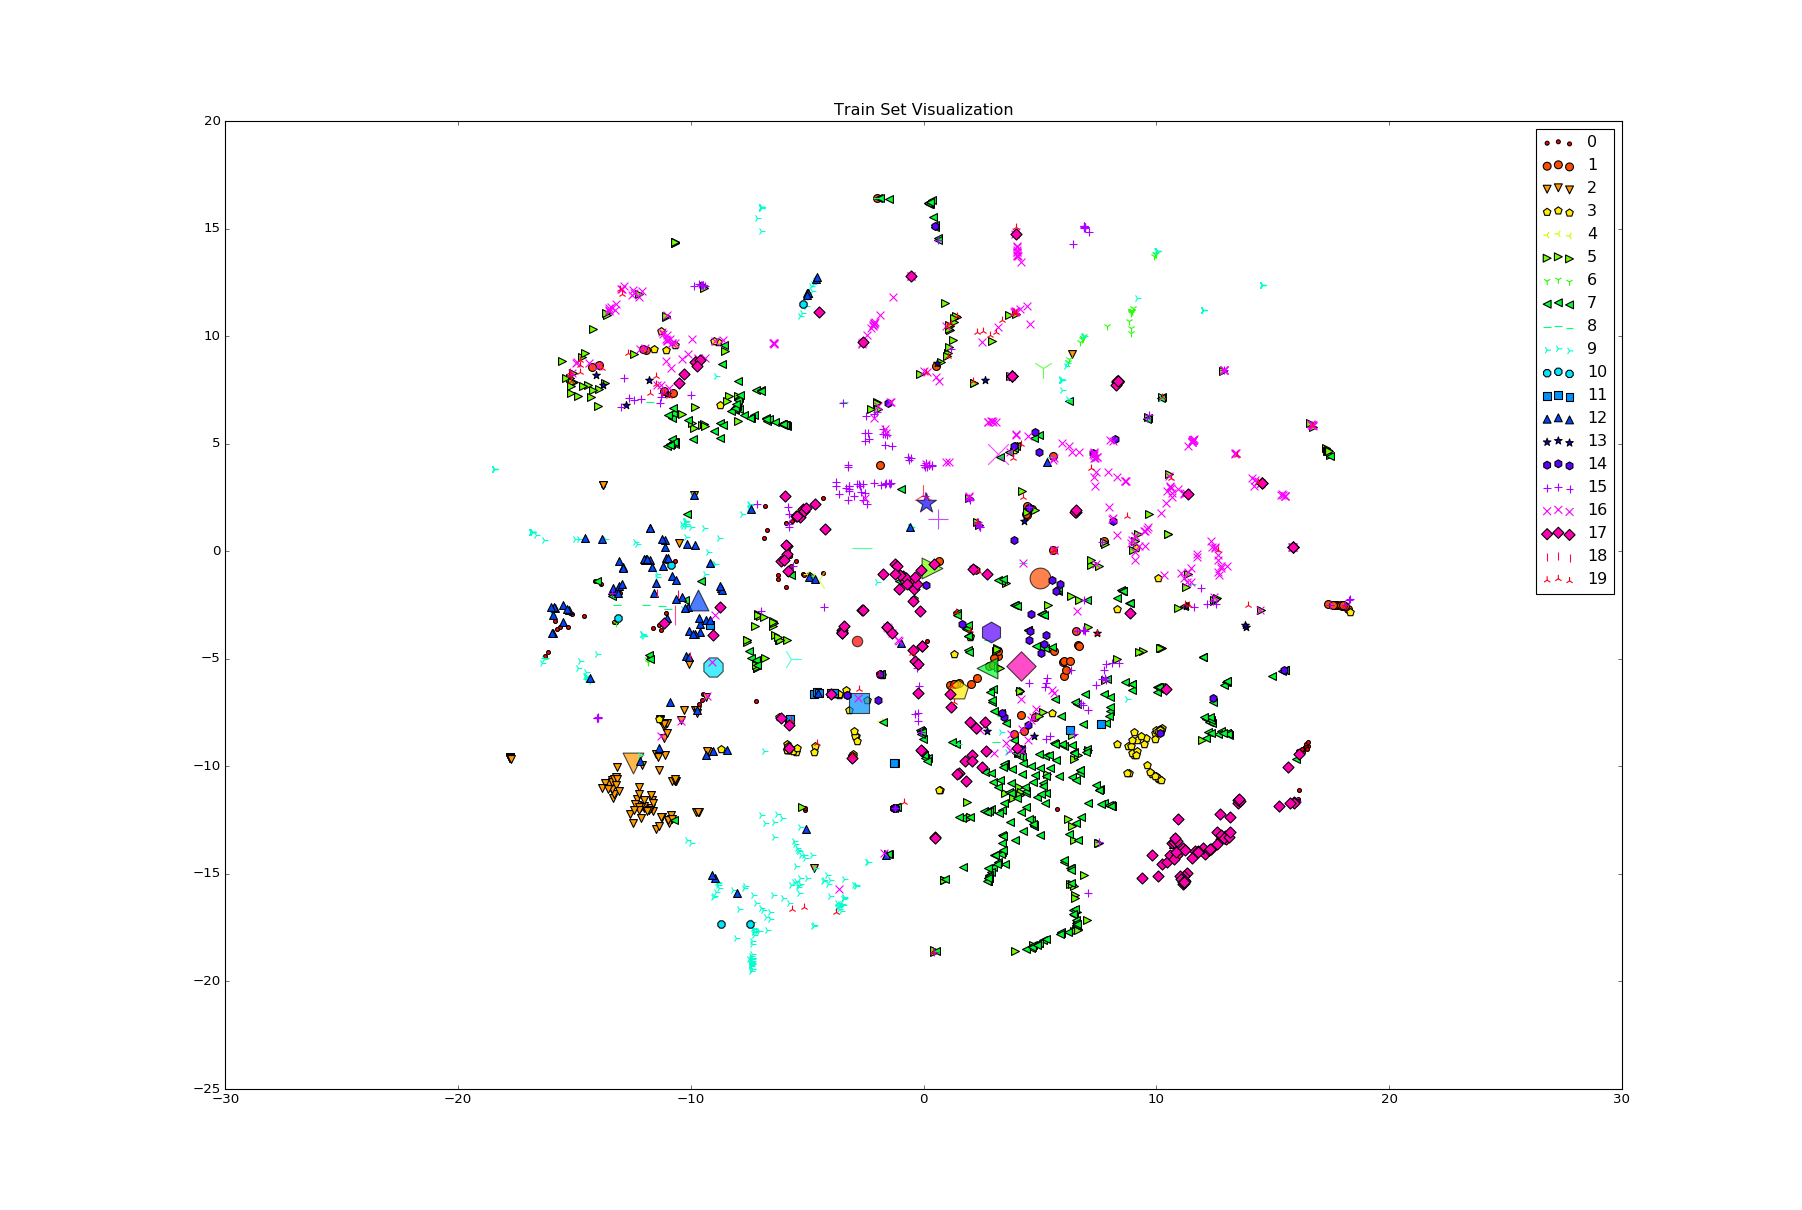

In [103]:
visualize_sparse_vector(X_train_final, y_train, clfs[0].n_classes_, 'Train Set Visualization')

2.38599991798 secs
LSA shape: (510L, 100L)
4.21400022507 secs
t-SNE shape: (510L, 2L)


<IPython.core.display.Javascript object>


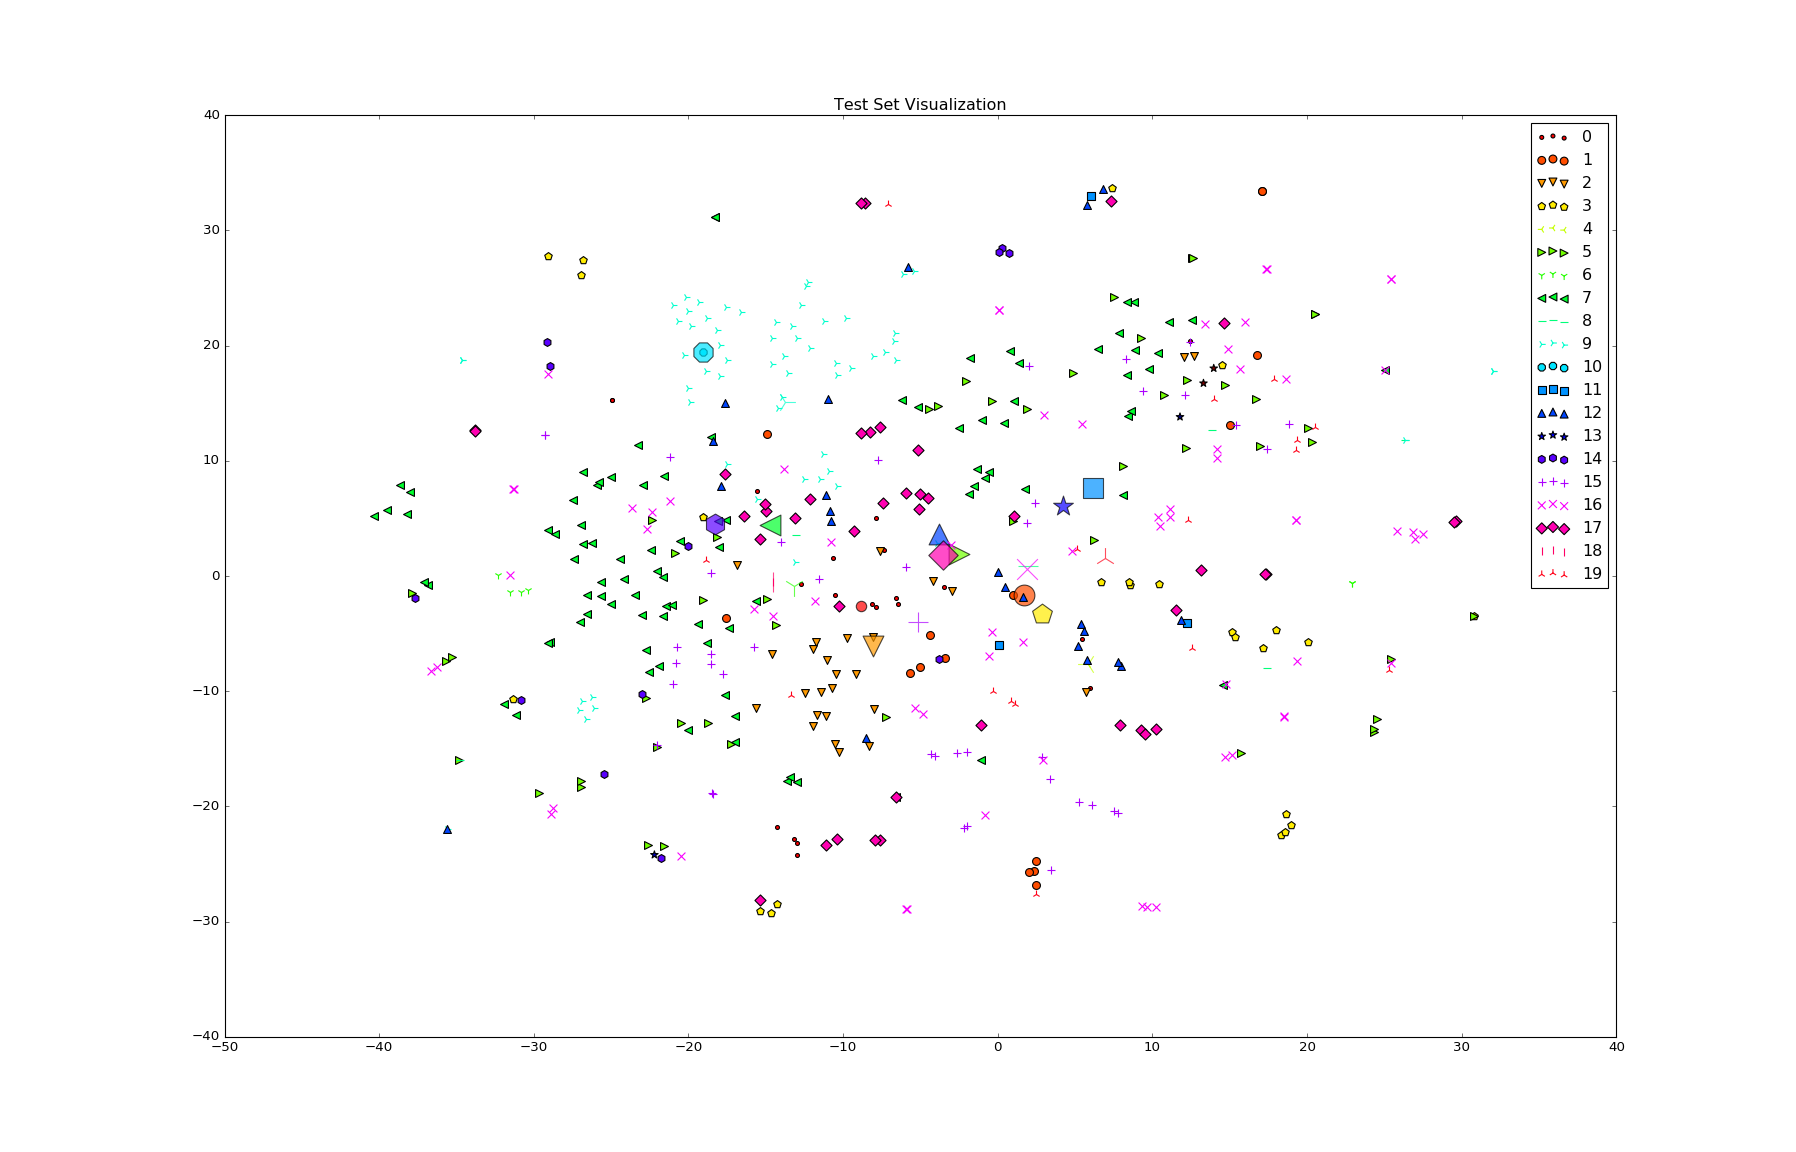

In [104]:
visualize_sparse_vector(X_test_final, y_test, clfs[0].n_classes_, 'Test Set Visualization')

In [5]:
str_labels = [u'0 บริหารธุรกิจ',
    u'1 ประมง',
    u'2 มนุษยศาสตร์',
    u'3 วนศาสตร์',
    u'4 วิทยาการจัดการ',
    u'5 วิทยาศาสตร์',
    u'6 วิทยาศาสตร์การกีฬา',
    u'7 วิศวกรรมศาสตร์',
    u'8 ศิลปศาสตร์และวิทยาศาสตร์',
    u'9 ศึกษาศาสตร์',
    u'10 ศึกษาศาสตร์และพัฒนศาสตร์',
    u'11 สถาปัตยกรรมศาสตร์',
    u'12 สังคมศาสตร์',
    u'13 สัตวแพทยศาสตร์',
    u'14 สิ่งแวดล้อม',
    u'15 อุตสาหกรรมเกษตร',
    u'16 เกษตร',
    u'17 เศรษฐศาสตร์',
    u'18 โครงการจัดตั้งวิทยาเขตสุพรรณบุรี',
    u'19 โครงการสหวิทยาการระดับบัณฑิตศึกษา']

In [ ]:
# # refitting on the whole dataset
# X_old, y_old = vstack([X_train_final, X_test_final]), np.concatenate([y_train, y_test])
# clf.fit(X_old, y_old)

In [6]:
clf = clfs[0]
print 'score:', clf.score(X_test_final, y_test)
proba = clf.predict_proba(X_test_final)
confidence = proba.max(1)
print 'confidence:', confidence.mean(), confidence.std(), confidence.min(), confidence.max()

score: 0.927450980392
confidence: 0.73368627451 0.220944806363 0.16 1.0


** Read segmented docs **

In [7]:
%%time
doc_path = u'./corpus/segmented-journal' # must be a segmented doc path
dataset_contents = []
filename2index = dict()
for i, filename in enumerate(os.listdir(doc_path)):
    path = os.path.join(doc_path, filename)
    filename2index[filename] = i
    with open(path) as f:
        content = f.read()
#         if chardet.detect(content)['encoding'] == 'ascii':
#             continue
        content = content.decode('utf8')
        dataset_contents.append(content)
print 'total files:', len(dataset_contents)

total files: 2165
Wall time: 45.4 s


# Apply learning pipeline to all the docs
First trim

In [8]:
%%time
for i in xrange(len(dataset_contents)):
    dataset_contents[i] = pretty_trim(dataset_contents[i])

Wall time: 5.86 s


Then count words and apply Tf-idf

In [9]:
%time X_new_count = counter.transform(dataset_contents)
%time X_new_tfidf = tfidf.transform(X_new_count)
print X_new_tfidf.shape

Wall time: 13.7 s
Wall time: 107 ms
(2165, 250000)


Remove some features

In [10]:
%time X_new_rfe = rfe.transform(X_new_tfidf)
print X_new_rfe.shape

Wall time: 42 ms
(2165, 20000)


Predict using trained models

In [11]:
y_pred = clf.predict(X_new_rfe)
Counter(y_pred)

Counter({0: 1,
         2: 1,
         3: 1,
         5: 1322,
         7: 15,
         9: 32,
         12: 2,
         15: 192,
         16: 575,
         17: 17,
         19: 7})

In [12]:
proba = clf.predict_proba(X_new_rfe)
confidence = proba.max(1)
print 'confidence:', confidence.mean(), confidence.std(), confidence.min(), confidence.max()

confidence: 0.457131639723 0.130549181945 0.13 0.92


Evaluate predict_proba on some files to roughly interpret the performance

In [ ]:
# filenames = ['A0906251543307343.txt', 'A1410221625383281.txt', 'A1006241011134591.txt', 'A1004071348071718.txt']
# # these are files that contain word 'department'
# indices = [filename2index[filename] for filename in filenames]
# labels = [str_labels[pred] for pred in y_pred[indices]]
# for label, prob in zip(labels, confidence[indices]):
#     print label, prob

In [ ]:
# # what is the label of all docs that contain word 'rice' ?
# preds = []
# for i, content in enumerate(dataset_contents):
#     if u'rice' in content.split():
#         preds.append((str_labels[y_pred[i]], confidence[i]))
# preds.sort(key=lambda item: item[1], reverse=True)
# for pred in preds:
#     print pred[0], pred[1]

## Synthesize approximated labels using heuristic

In [30]:
# [word -> class_label] mapping dictioanry
approx_label = {
#     "liber": 8,
#     "art": 8,
    "agricultur": 16,
    "agro": 16,
    "educ": 9,
#     "social": 12,
#     "fisheri": 1,
#     "manag": 4,
    "scienc": 5,
    "technolog": 5,
#     "medicin": 13,
#     "pharmaci": 13,
#     "forestri": 3,
#     "forest": 3,
    "engin": 7,
    "econom": 17,
    "architectur": 11,
#     "human": 2,
    "biotechnolog": 5,
#     "environment": 14,
#     "environ": 14,
#     "veterinari": 13,
#     "busi": 0,
#     u"ธุรกิจ": 0,
}
approx_label_detailed = {
    "liber": 8,
    "art": 8,
    "agricultur": 16,
    "agro": 16,
    "educ": 9,
    "social": 12,
    "fisheri": 1,
    "manag": 4,
    "scienc": 5,
    "technolog": 5,
    "medicin": 13,
    "pharmaci": 13,
    "forestri": 3,
    "forest": 3,
    "engin": 7,
    "econom": 17,
    "architectur": 11,
    "human": 2,
    "biotechnolog": 5,
    "environment": 14,
    "environ": 14,
    "veterinari": 13,
    "busi": 0,
    u"ธุรกิจ": 0,
}

Find approximated labels by searching for the faculty name

In [34]:
def find_heuristic_y(approx_label):
    heuristic_y = np.zeros(len(dataset_contents), dtype=np.int32) - 1 # starts with -1 filled
    for ci in range(len(dataset_contents)):
        words = dataset_contents[ci].split()
        contexts = []
        wis = []
        for wi, word in enumerate(words):
            if u'faculti' in word or u'คณะ' in word:
                context = words[wi-3:wi+5]
                contexts.append(context)
                wis.append(wi)
                for w in context:
                    if w in approx_label:
                        heuristic_y[ci] = approx_label[w]
                        break
            if heuristic_y[ci] != -1:
                break
        if contexts: # logging
            label = str_labels[heuristic_y[ci]] if heuristic_y[ci] != -1 else 'UNKNOWN'
            print 'Document No.', ci, '(', label, ')'

            for i in range(len(contexts)):
                print 'Word No.', wis[i], ' => ',
                for w in contexts[i]:
                    if w in approx_label:
                        w = '[%s]' % w
                    print w,
                print
    return heuristic_y, heuristic_y != -1 # test data that do not have approximated label would be invalid

In [35]:
heuristic_y, valid_mask = find_heuristic_y(approx_label)
print 'Total Label Approximations:', np.count_nonzero(valid_mask)

Document No. 0 ( 16 เกษตร )
Word No. 291  =>  of plant patholog faculti of [agricultur] kasetsart univers
Document No. 1 ( 5 วิทยาศาสตร์ )
Word No. 12  =>  2550 [scienc] [educ] faculti of [educ] kasetsart univers
Document No. 2 ( 5 วิทยาศาสตร์ )
Word No. 23  =>  for [scienc] [educ] faculti of [educ] kasetsart univers
Document No. 3 ( 17 เศรษฐศาสตร์ )
Word No. 15  =>  home [econom] [educ] faculti of [educ] kasetsart univers
Document No. 4 ( UNKNOWN )
Word No. 22  =>  univers chiangrai thailand faculti of medicin maha sara
Document No. 5 ( 9 ศึกษาศาสตร์ )
Word No. 15  =>  depart of [educ] faculti of [educ] kasetsart univers
Document No. 7 ( 16 เกษตร )
Word No. 18  =>  extens and communic faculti of [agricultur] kasetsart univers
Document No. 8 ( 16 เกษตร )
Word No. 18  =>  extens and communic faculti of [agricultur] at kamphaeng
Document No. 10 ( 16 เกษตร )
Word No. 18  =>  extens and communic faculti of [agricultur] at kamphaeng
Document No. 11 ( 5 วิทยาศาสตร์ )
Word No. 23  =>  muang p

In [36]:
heuristic_y_detailed, valid_mask_detailed = find_heuristic_y(approx_label_detailed)
print 'Total Label Approximations Detailed:', np.count_nonzero(valid_mask_detailed)

Document No. 0 ( 16 เกษตร )
Word No. 291  =>  of plant patholog faculti of [agricultur] kasetsart univers
Document No. 1 ( 5 วิทยาศาสตร์ )
Word No. 12  =>  2550 [scienc] [educ] faculti of [educ] kasetsart univers
Document No. 2 ( 5 วิทยาศาสตร์ )
Word No. 23  =>  for [scienc] [educ] faculti of [educ] kasetsart univers
Document No. 3 ( 17 เศรษฐศาสตร์ )
Word No. 15  =>  home [econom] [educ] faculti of [educ] kasetsart univers
Document No. 4 ( 13 สัตวแพทยศาสตร์ )
Word No. 22  =>  univers chiangrai thailand faculti of [medicin] maha sara
Document No. 5 ( 9 ศึกษาศาสตร์ )
Word No. 15  =>  depart of [educ] faculti of [educ] kasetsart univers
Document No. 7 ( 16 เกษตร )
Word No. 18  =>  extens and communic faculti of [agricultur] kasetsart univers
Document No. 8 ( 16 เกษตร )
Word No. 18  =>  extens and communic faculti of [agricultur] at kamphaeng
Document No. 10 ( 16 เกษตร )
Word No. 18  =>  extens and communic faculti of [agricultur] at kamphaeng
Document No. 11 ( 5 วิทยาศาสตร์ )
Word No. 23 

### Evaluate accuracy score on approximated labels

In [46]:
print 'Accuracy:', accuracy_score(heuristic_y[valid_mask], y_pred[valid_mask])
print Counter(heuristic_y[valid_mask])
print Counter(y_pred[valid_mask])
print
print 'Accuracy Detailed:', accuracy_score(heuristic_y_detailed[valid_mask_detailed], y_pred[valid_mask_detailed])
print Counter(heuristic_y_detailed[valid_mask_detailed])
print Counter(y_pred[valid_mask_detailed])

Accuracy: 0.564070351759
Counter({5: 845, 16: 462, 7: 133, 9: 89, 17: 56, 11: 7})
Counter({5: 955, 16: 408, 15: 169, 9: 25, 17: 14, 7: 12, 19: 6, 0: 1, 3: 1, 12: 1})

Accuracy Detailed: 0.441988950276
Counter({5: 730, 16: 445, 13: 134, 7: 123, 9: 84, 1: 65, 3: 57, 17: 53, 2: 25, 12: 25, 14: 22, 8: 17, 4: 14, 0: 10, 11: 6})
Counter({5: 1115, 16: 462, 15: 169, 9: 27, 17: 14, 7: 12, 19: 7, 0: 1, 2: 1, 3: 1, 12: 1})


In [47]:
print "Confidence score on valid_mask:", clf.predict_proba(X_new_rfe[valid_mask]).max(1).mean()
print "Confidence score on valid_mask_detailed:", clf.predict_proba(X_new_rfe[valid_mask_detailed]).max(1).mean()

Confidence score on valid_mask: 0.474987437186
Confidence score on valid_mask_detailed: 0.464939226519


### Predict top K confident labels
**k** can be a float to represent minimum cumulative sum of the probability, or an int specifying constant number of predictions

If **k** is an integer, it will be the constant number of predictions to make for each sample

If **k** is a fraction, it will be the minimum confidence score.
The model would automatically choose different number of predictions for each sample.

For example, if a model is very confident that 'X' should be assigned to class 'Y' or 'Z' with the probability of 50% and 30% respectively then it would need only 2 predictions to do the job if you specify **k** to be <=  _0.80_.

**Constant predictions** (if k=2, it means that all samples are predicted 2 times)

In [49]:
for i in range(1, 9):
    score = score_top_preds(clf, X_new_rfe[valid_mask], heuristic_y[valid_mask], i)
    print 'Accuracy score (k=%d):' % i, score
for i in range(1, 9):
    score = score_top_preds(clf, X_new_rfe[valid_mask_detailed], heuristic_y_detailed[valid_mask_detailed], i)
    print 'Accuracy score detailed (k=%d):' % i, score

Accuracy score (k=1): 0.560929648241
Accuracy score (k=2): 0.836683417085
Accuracy score (k=3): 0.951633165829
Accuracy score (k=4): 0.974246231156
Accuracy score (k=5): 0.984924623116
Accuracy score (k=6): 0.991206030151
Accuracy score (k=7): 0.994346733668
Accuracy score (k=8): 0.995603015075
Accuracy score detailed (k=1): 0.440883977901
Accuracy score detailed (k=2): 0.675138121547
Accuracy score detailed (k=3): 0.832596685083
Accuracy score detailed (k=4): 0.87182320442
Accuracy score detailed (k=5): 0.895580110497
Accuracy score detailed (k=6): 0.91546961326
Accuracy score detailed (k=7): 0.928729281768
Accuracy score detailed (k=8): 0.939226519337


**Varying predictions** (if k=0.75, it means that the model must predict as many times as needed to satisfy its confidence score of 75%)

<IPython.core.display.Javascript object>


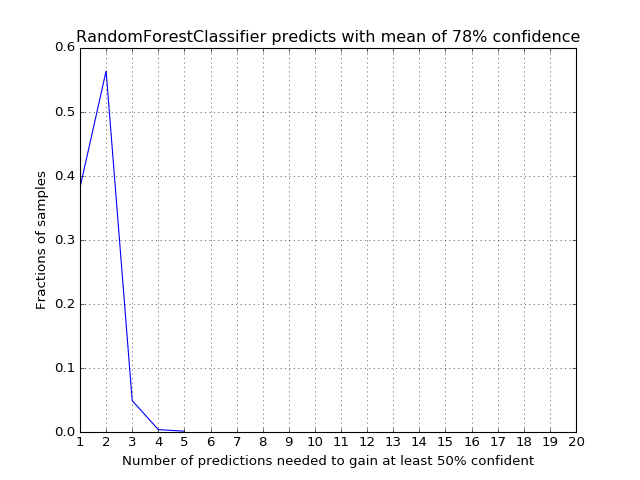

Mean number of predictions: 1.6783919598
Accuracy score (k=0.50): 0.768216080402


<IPython.core.display.Javascript object>


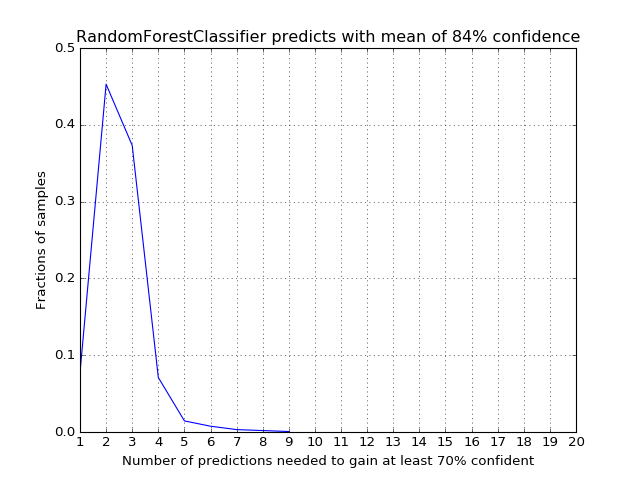

Mean number of predictions: 2.53140703518
Accuracy score (k=0.70): 0.941582914573


<IPython.core.display.Javascript object>


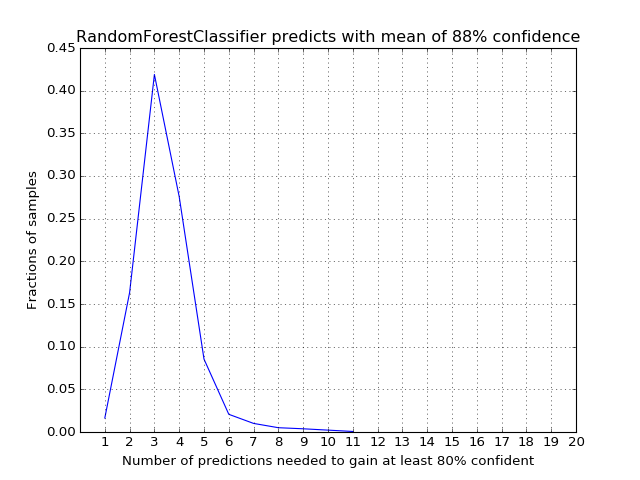

Mean number of predictions: 3.40577889447
Accuracy score (k=0.80): 0.973618090452


<IPython.core.display.Javascript object>


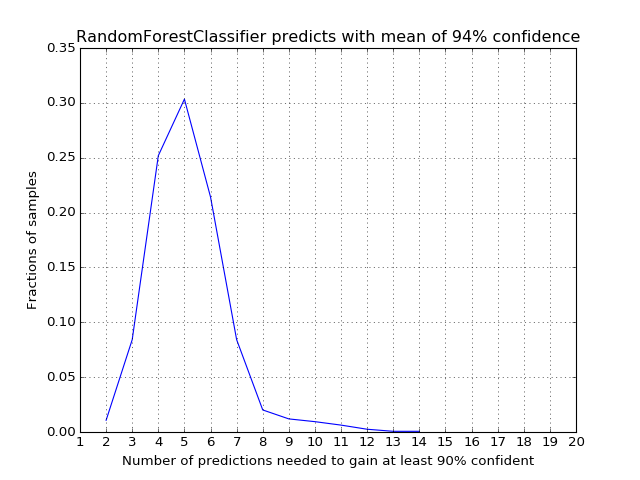

Mean number of predictions: 5.15138190955
Accuracy score (k=0.90): 0.989949748744


<IPython.core.display.Javascript object>


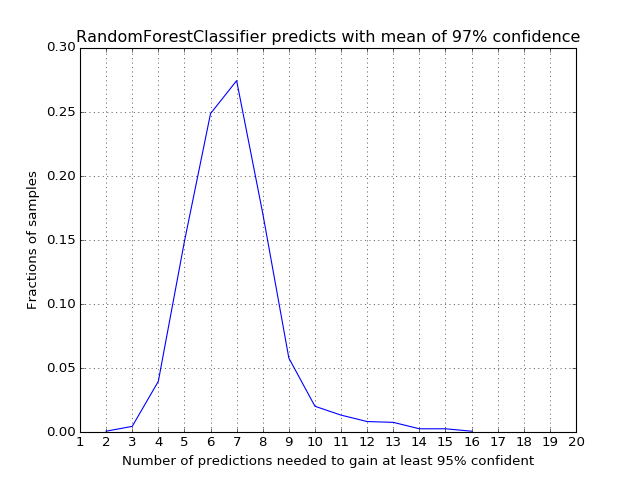

Mean number of predictions: 6.84296482412
Accuracy score (k=0.95): 0.992462311558


<IPython.core.display.Javascript object>


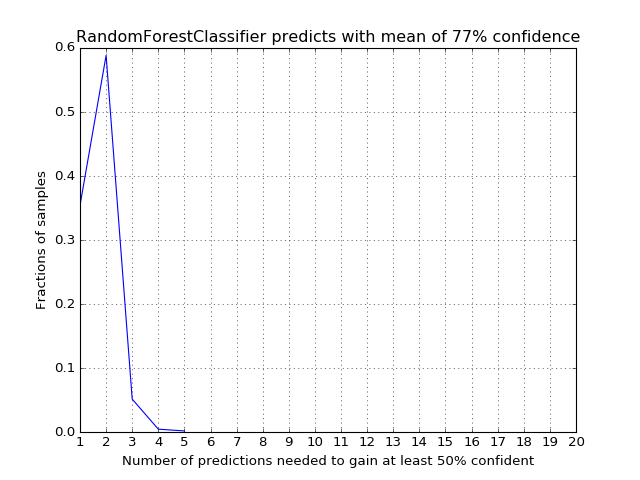

Mean number of predictions: 1.71104972376
Accuracy score detailed (k=0.50): 0.616574585635


<IPython.core.display.Javascript object>


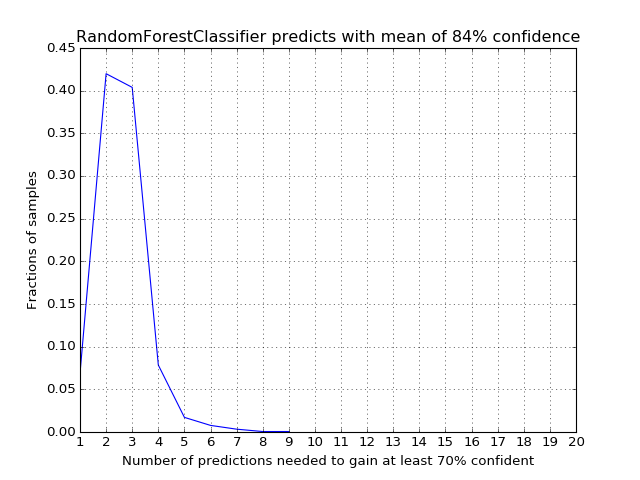

Mean number of predictions: 2.59834254144
Accuracy score detailed (k=0.70): 0.823756906077


<IPython.core.display.Javascript object>


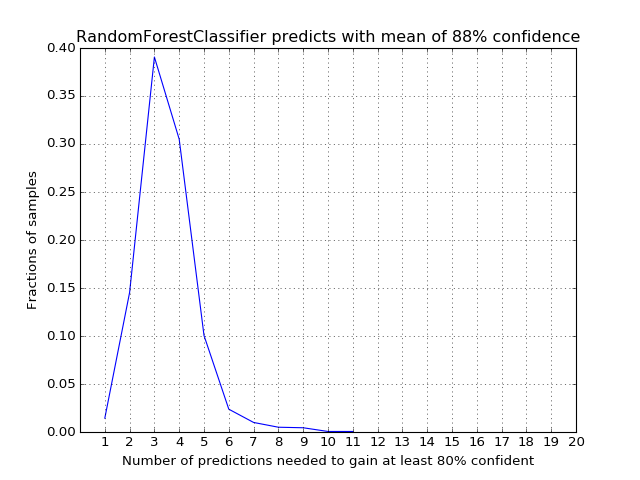

Mean number of predictions: 3.50276243094
Accuracy score detailed (k=0.80): 0.869060773481


<IPython.core.display.Javascript object>


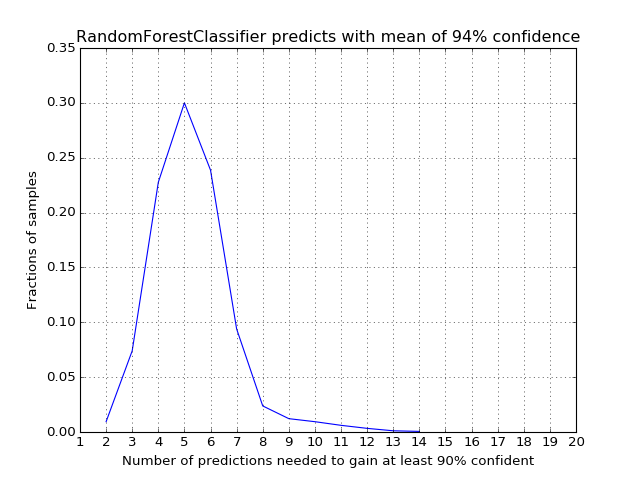

Mean number of predictions: 5.26298342541
Accuracy score detailed (k=0.90): 0.910497237569


<IPython.core.display.Javascript object>


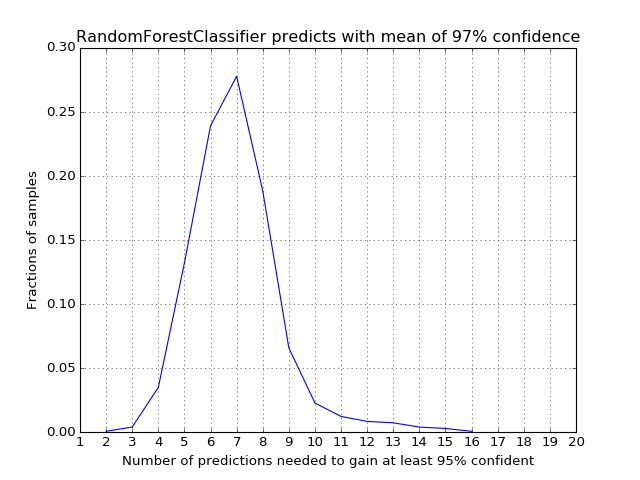

Mean number of predictions: 6.94917127072
Accuracy score detailed (k=0.95): 0.933149171271


In [51]:
for confidence in [0.5, 0.7, 0.8, 0.9, 0.95]:
    score = score_top_preds(clf, X_new_rfe[valid_mask], heuristic_y[valid_mask], confidence)
    print 'Accuracy score (k=%.2f):' % confidence, score
for confidence in [0.5, 0.7, 0.8, 0.9, 0.95]:
    score = score_top_preds(clf, X_new_rfe[valid_mask_detailed], heuristic_y_detailed[valid_mask_detailed], confidence)
    print 'Accuracy score detailed (k=%.2f):' % confidence, score